## Pythonによるマーケティングミックスモデリング （MMM：Marketing Mix Modeling） 超入門 その3 ちょっと複雑なアドストック（Ad Stock）を考慮した線形回帰モデル

url: https://www.salesanalytics.co.jp/datascience/datascience099/

url: https://www.salesanalytics.co.jp/mmm-intro/

    本当に売上に貢献している広告は、どの広告か？

    売上と広告媒体等との関係性をモデリングし、どの広告媒体が売上にどれほど貢献していたのか分析することができます。

    それが、マーケティングミックスモデリング（MMM：Marketing Mix Modeling）です。

    前回、「アドストック（Ad Stock）を考慮した線形回帰モデル」というお話しをしました。

    url: https://www.salesanalytics.co.jp/datascience/datascience098/

    ちなみに、アドストック（Ad Stock）を考慮するとは、飽和効果（収穫逓減）とキャリーオーバー（Carryover）効果を考慮するということです。

    具体的には、Pythonのscikit-learn（sklearn）のパイプラインを、以下のように構築しました。

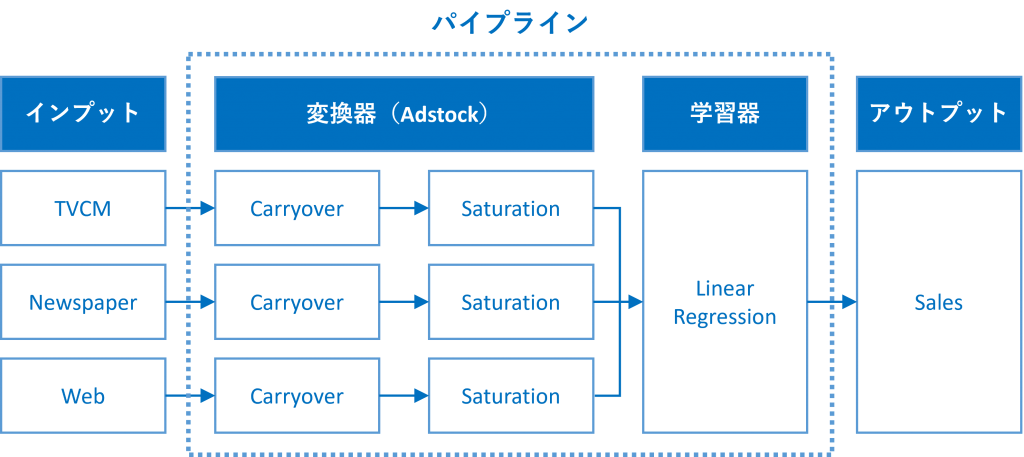

    前回の、飽和モデルとキャリーオーバー効果モデルは非常にシンプルなものでした。
    今回は、ちょっと複雑な飽和モデルとキャリーオーバー効果モデルを利用します。

    ということは、今回は「ちょっと複雑なアドストック（Ad Stock）を考慮した線形回帰モデル」というお話しをします。

## 利用するデータセット（前回と同じ）
    今回利用するデータセットの変数です。

    Week：週
    Sales：売上
    TVCM：TV CMのコスト
    Newspaper：新聞の折り込みチラシのコスト
    Web：Web広告のコスト

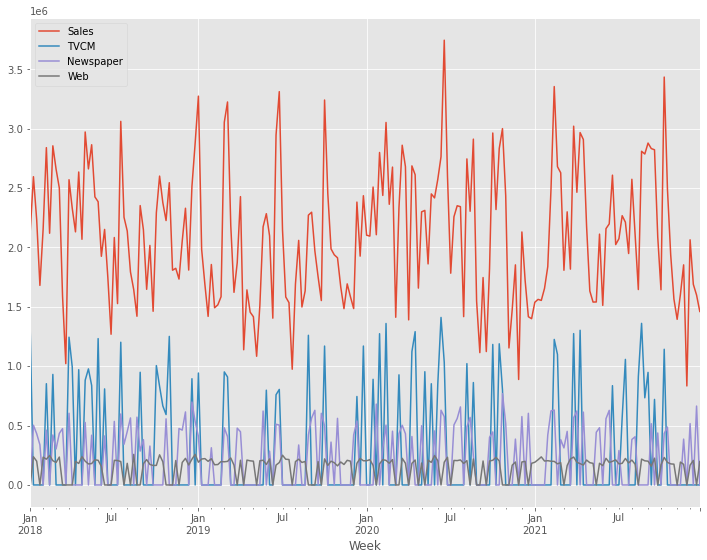

    以下からダウンロードできます。

    MMM.csv
    https://www.salesanalytics.co.jp/4zdt

## 今回利用するキャリーオーバー効果モデル
    先ずは、前回のキャリーオーバー効果モデルの復習です。

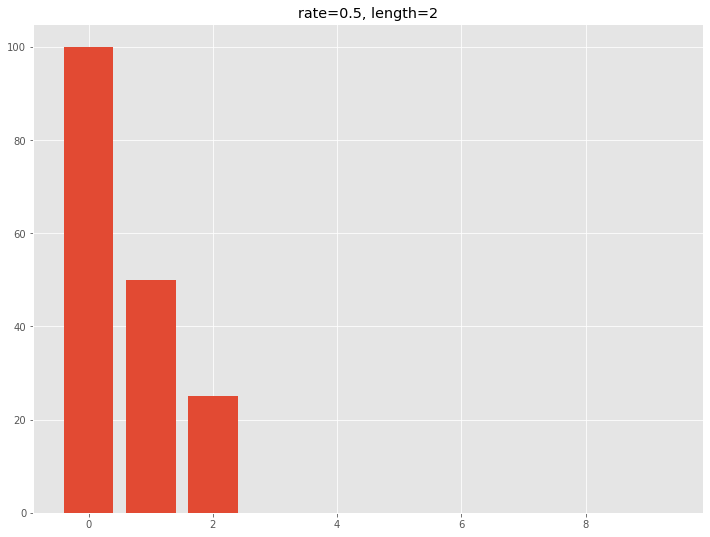

    広告などを打ったときが効果のピークで、徐々に効果が一定の割合で減衰していくモデルです。
    例えば、100あった効果が、次期に50になり、次々期に25になるといった具合です。
    この例の場合、50%の割合で効果が減衰しています。

    しかし、広告などは、広告などを打ったときが効果のピークとは限りません。
    例えば、広告を打った数日後や数週間後に効果のピークが来ることもあります。

    今回は、効果のピークが広告などを打ったときに限らないモデルを使います。

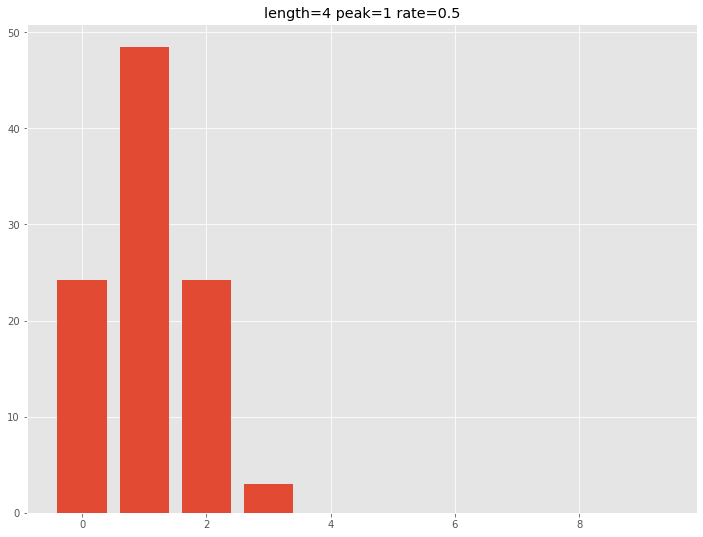

    数式で表現すると、次のようになります。

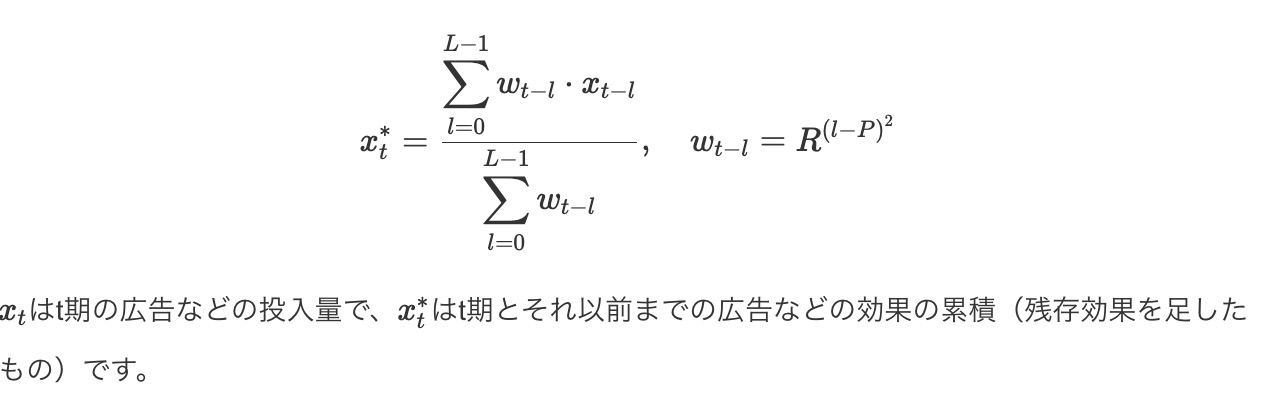

## キャリーオーバー効果モデル

    ハイパーパラメータは、次の3つです。

    L(length)：効果の続く期間　※当期含む
    P(peak)：ピークの時期（広告などを打った日の場合は0、次期は1、など）
    R(rate)：減衰率

    例えば、隔期に広告を100打った場合、それが積み重なります。

    ・当期：100
    ・次期：50
    ・次々期：25+100=125
    ・次次々期：12.5+50=62.5
    ・次次次々期：0+25+100=125
    ・次次次次々期：0+12.5+50=62.5

## 今回利用する飽和モデル
    先ずは、前回の飽和モデルの復習です。

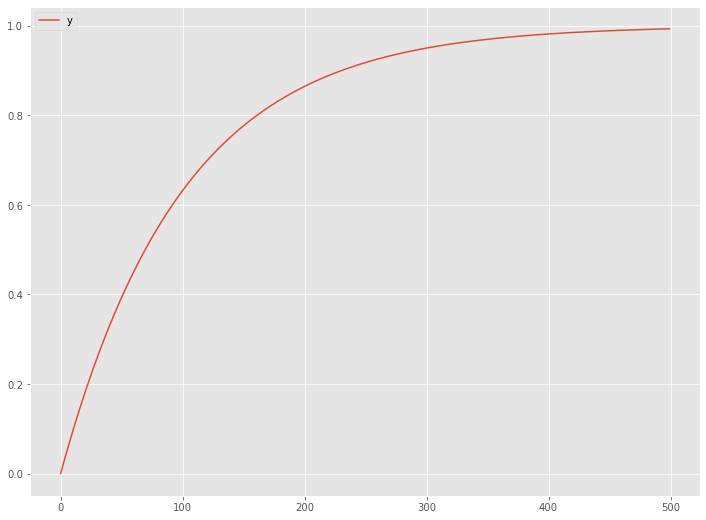

    最もシンプルな指数関数 1−e**−axでモデル化しました。

    今回は、S字曲線を表現する関数でモデル化します。
    シグモイド関数やロジスティック曲線、ゴンペルツ曲線など色々あります。

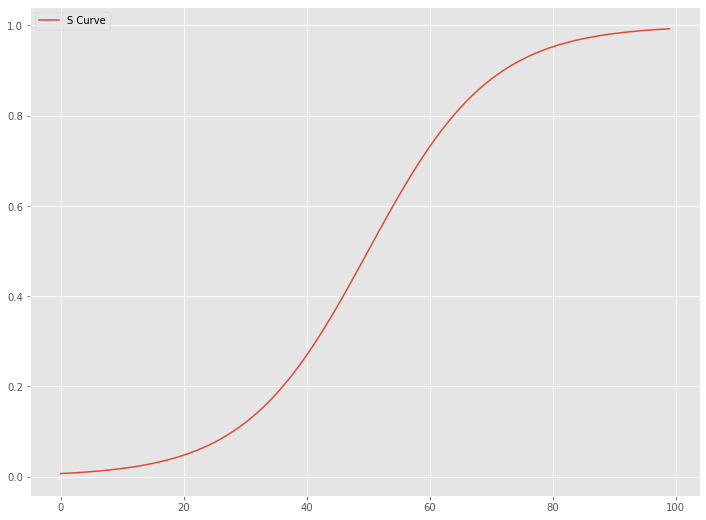

    今回は、以下の数式で表現されたロジスティック曲線でモデル化します。

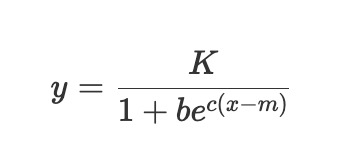

    ハイパーパラメータは、次の4つです。

    K：上限パラメータ
    b：形状パラメータ
    c：形状パラメータ
    m：位置パラメータ

## MMMの実施
### 必要なライブラリーの読み込み
    必要なライブラリーを読み込みます。

    以下、コードです。

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

from scipy.signal import convolve2d

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn import set_config

from sklearn.linear_model import LinearRegression

from optuna.integration import OptunaSearchCV
from optuna.distributions import UniformDistribution, IntUniformDistribution

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ

#指数表記しない設定
np.set_printoptions(precision=3,suppress=True)
pd.options.display.float_format = '{:.3f}'.format

## データセットの読み込み（前回と同じ）
    データセットを読み込みます。

    以下、コードです。

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 208 entries, 2018-01-07 to 2021-12-26
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sales      208 non-null    int64
 1   TVCM       208 non-null    int64
 2   Newspaper  208 non-null    int64
 3   Web        208 non-null    int64
dtypes: int64(4)
memory usage: 8.1 KB
None
              Sales     TVCM  Newspaper     Web
Week                                           
2018-01-07  2132000  1312200          0       0
2018-01-14  2596100        0     502900  237400
2018-01-21  2236200        0     432100  200600
2018-01-28  1680900        0     338400       0
2018-02-04  2155400        0          0  234000


<Axes: xlabel='Week'>

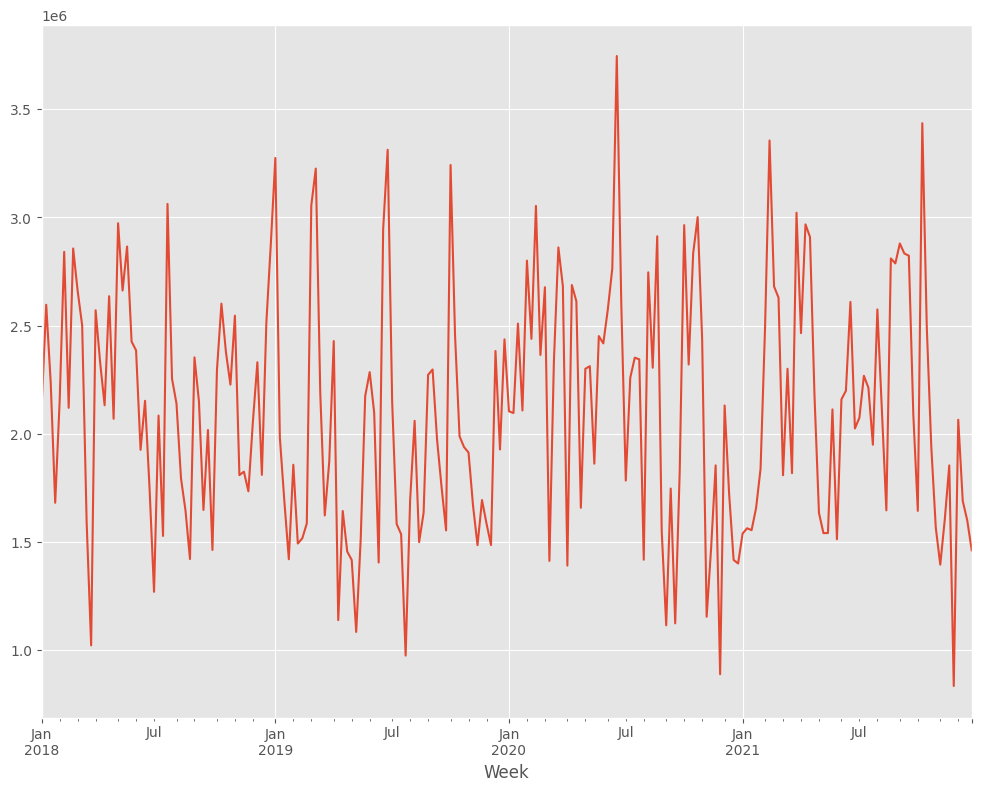

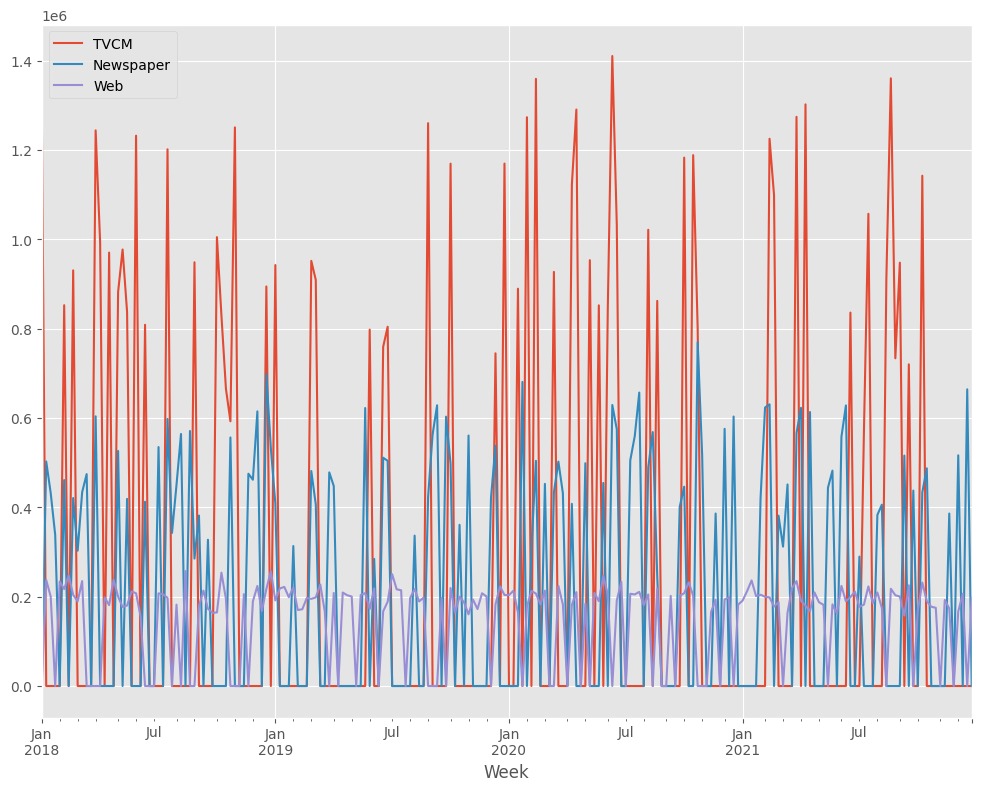

In [3]:
# データセット読み込み
url = 'https://www.salesanalytics.co.jp/4zdt'
df = pd.read_csv(url,
                 parse_dates=['Week'],
                 index_col='Week'
                )

# データ確認
print(df.info()) #変数の情報
print(df.head()) #データの一部

# 説明変数Xと目的変数yに分解
X = df.drop(columns=['Sales'])
y = df['Sales']

# グラフ化
y.plot()
X.plot()

## アドストックを考慮しない線形回帰モデル
    アドストックを考慮しない線形回帰モデルを構築し、どの程度の精度を持ったものだったのかを見てみます。

    ちなみに、前回と同じものです。

    線形回帰モデルのインスタンスを作ります。

    以下、コードです。

In [4]:
# 線形回帰モデルのインスタンス
lr = LinearRegression()

    線形回帰モデルが、どの程度の予測精度を持ったモデルになるのかを確かめるために、
    時系列のCV（クロスバリデーション）を実施します。今回は、デフォルトの5分割のCVです。

    以下、コードです。

In [5]:
# クロスバリデーションで精度検証（R2）
np.mean(cross_val_score(lr,
                        X, y,
                        cv=TimeSeriesSplit()
                       )
       )

0.7027465640779165

    全データでモデルを構築し、予測精度（R**2）を見てみます。

    以下、コードです。

In [ ]:
# 全データで精度検証（R2）
lr.fit(X, y)
lr.score(X, y)

0.7400400171566186

## アドストックの関数
    以下の2つのモデル（変換器）の関数を定義し利用することで、アドストックを表現します。

    ・飽和モデル
    ・キャリーオーバー効果モデル

## 飽和モデル
    飽和モデル（関数）を定義します。今回利用するのは、
    以下のロジスティック曲線です。

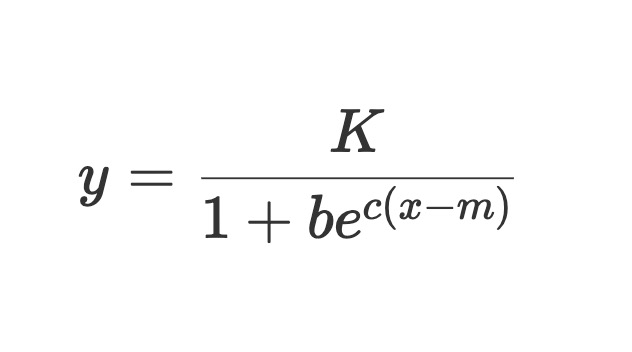

    ハイパーパラメータは、次の4つです。

    K：上限パラメータ
    b：形状パラメータ
    c：形状パラメータ
    m：位置パラメータ

    以下、コードです。

In [6]:
# 飽和モデル（関数）の定義
def Saturation(X,K,b,c,m):
    return K/(1+b*np.exp(-c*(X-m)))

    この関数の実行例です。

    以下、コードです。

<Axes: >

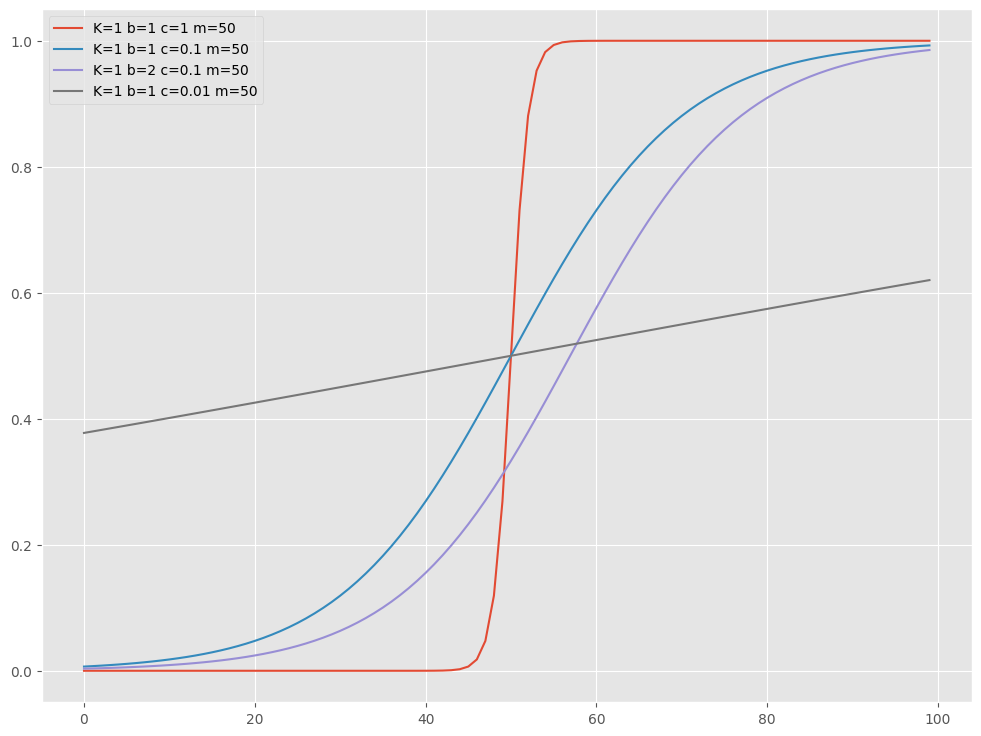

In [7]:
# 飽和モデル（関数）の例
exp_dat = pd.DataFrame(range(100)) #入力データ

exp_sat = pd.DataFrame(index=exp_dat.index)
exp_sat['K=1 b=1 c=1 m=50'] = Saturation(exp_dat,1,1,1,50)
exp_sat['K=1 b=1 c=0.1 m=50'] = Saturation(exp_dat,1,1,0.1,50)
exp_sat['K=1 b=2 c=0.1 m=50'] = Saturation(exp_dat,1,2,0.1,50)
exp_sat['K=1 b=1 c=0.01 m=50'] = Saturation(exp_dat,1,1,0.01,50)

exp_sat.plot() #グラフ

## キャリーオーバー効果モデル
    キャリーオーバー効果モデル（関数）を定義します。今回利用するのは、効果のピークが広告などを打ったときに限らない以下のモデルです。

    xtはt期の広告などの投入量で、
    xt∗はt期とそれ以前までの広告などの効果の累積（残存効果を足したもの）です。

    ハイパーパラメータは、次の3つです。

    L(length)：効果の続く期間（広告などを打った日も含む）
    P(peak)：ピークの時期（広告などを打った日の場合は0、次期は1、など）
    R(rate)：減衰率

    以下、コードです。

In [8]:
def Carryover(X: np.ndarray, length, peak, rate):
    X = np.append(np.zeros(length-1), X)

    Ws = np.zeros(length)

    for l in range(length):
        W = rate**((l-peak)**2)
        Ws[length-1-l] = W

    carryover_X = []

    for i in range(length-1, len(X)):
        X_array = X[i-length+1:i+1]
        Xi = sum(X_array * Ws)/sum(Ws)
        carryover_X.append(Xi)

    return np.array(carryover_X)


    最初100でその後0であるシンプルなケースの、この関数の実行例です。

    以下、コードです。

Text(0.5, 1.0, 'length=4 peak=1 rate=0.5')

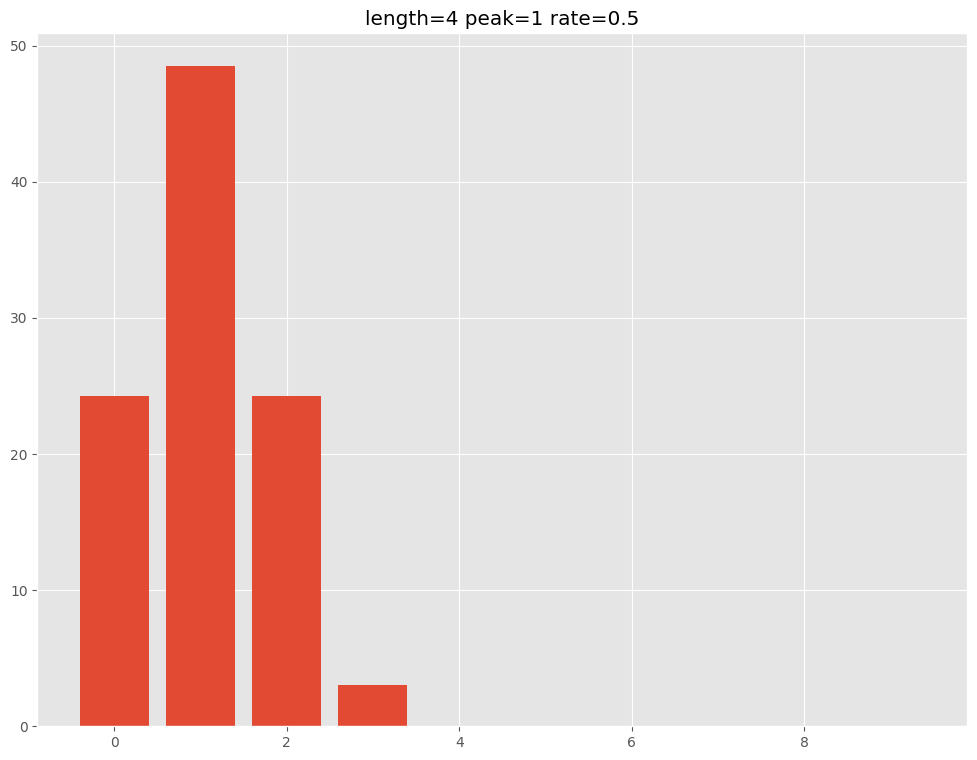

In [9]:
# キャリーオーバー効果モデル（関数）の例

## サンプルデータ
exp_dat = pd.DataFrame([100,0,0,0,0,0,0,0,0,0])

## キャリーオーバー効果
exp_co = Carryover(exp_dat, 4, 1, 0.5)

plt.bar(exp_dat.index,exp_co) #グラフ
plt.title('length=4 peak=1 rate=0.5')

## アドストックを考慮した線形回帰モデル
    パイパーパラメータを設定します。

    以下、コードです。

In [10]:
# TVCMのハイパーパラメータの設定
TVCM_carryover_length = 5
TVCM_carryover_peak = 1
TVCM_carryover_rate = 0.5
TVCM_saturation_K = 1
TVCM_saturation_b = 1
TVCM_saturation_c = 0.1
TVCM_saturation_m = np.mean(X.TVCM)

# Newspaperのハイパーパラメータの設定
Newspaper_carryover_length = 3
Newspaper_carryover_peak = 0
Newspaper_carryover_rate = 0.5
Newspaper_saturation_K = 1
Newspaper_saturation_b = 1
Newspaper_saturation_c = 0.1
Newspaper_saturation_m = np.mean(X.Newspaper)

# Webのハイパーパラメータの設定
Web_carryover_length = 1
Web_carryover_peak = 0
Web_carryover_rate = 0.5
Web_saturation_K = 1
Web_saturation_b = 1
Web_saturation_c = 0.1
Web_saturation_m = np.mean(X.Web)

    どのようなキャリーオーバー効果なのかを見てみます。

    以下、コードです。



Text(0.5, 1.0, 'Web')

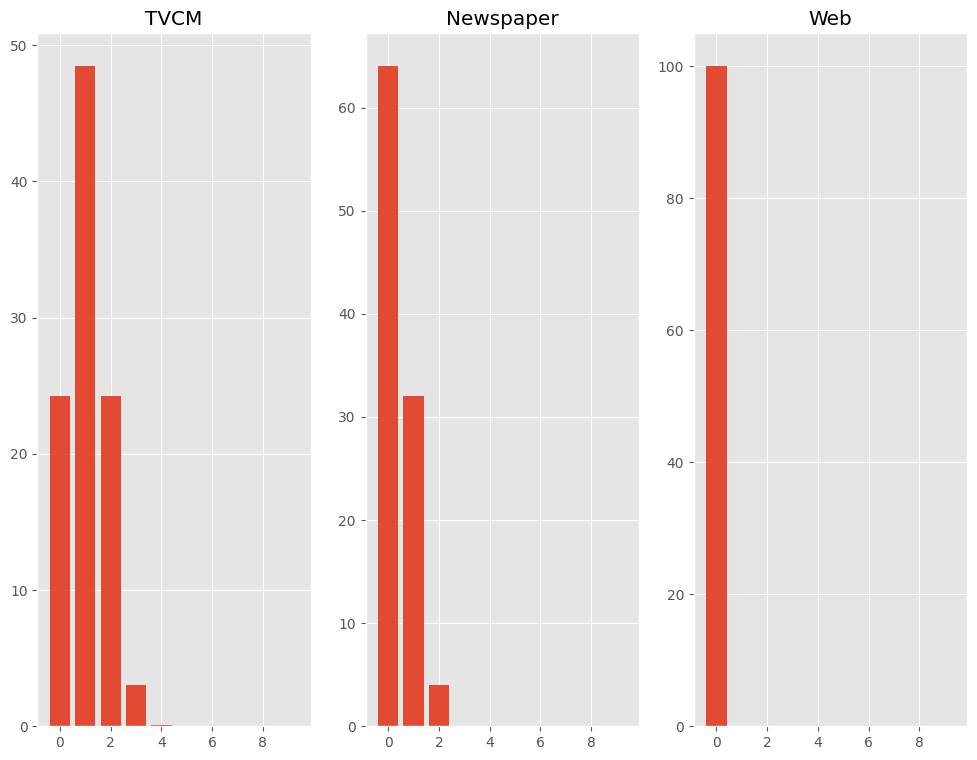

In [11]:
# キャリーオーバー効果モデルの出力例

## サンプルデータ
exp_dat = pd.DataFrame([100,0,0,0,0,0,0,0,0,0])

## キャリーオーバー効果

### TVCM
exp_co_TVCM= Carryover(
    exp_dat,
    TVCM_carryover_length,
    TVCM_carryover_peak,
    TVCM_carryover_rate
)

### Newspaper
exp_co_Newspaper = Carryover(
    exp_dat,
    Newspaper_carryover_length,
    Newspaper_carryover_peak,
    Newspaper_carryover_rate
)

### Web
exp_co_Web = Carryover(
    exp_dat,
    Web_carryover_length,
    Web_carryover_peak,
    Web_carryover_rate
)

## グラフ
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False)

### TVCM
axes[0].bar(exp_dat.index,
            exp_co_TVCM
           )
axes[0].set_title('TVCM')

### Newspaper
axes[1].bar(exp_dat.index,
            exp_co_Newspaper
           )
axes[1].set_title('Newspaper')

### Web
axes[2].bar(exp_dat.index,
            exp_co_Web
           )
axes[2].set_title('Web')

    説明変数X（広告などのコスト）のデータに対し、
    キャリーオーバー効果モデルと飽和モデルを使い、学習器（線形回帰モデル）のインプットを作ります。

    以下、コードです。

In [12]:
# TVの値の変換
X_TVCM = Saturation(Carryover(X[['TVCM']],
                              TVCM_carryover_length,
                              TVCM_carryover_peak,
                              TVCM_carryover_rate).reshape(-1,1),
                    TVCM_saturation_K,
                    TVCM_saturation_b,
                    TVCM_saturation_c,
                    TVCM_saturation_m
                   )

# Newspaperの値の変換
X_Newspaper = Saturation(Carryover(X[['Newspaper']],
                              Newspaper_carryover_length,
                              Newspaper_carryover_peak,
                              Newspaper_carryover_rate).reshape(-1,1),
                    Newspaper_saturation_K,
                    Newspaper_saturation_b,
                    Newspaper_saturation_c,
                    Newspaper_saturation_m
                   )

# Webの値の変換
X_Web = Saturation(Carryover(X[['Web']],
                              Web_carryover_length,
                              Web_carryover_peak,
                              Web_carryover_rate).reshape(-1,1),
                    Web_saturation_K,
                    Web_saturation_b,
                    Web_saturation_c,
                    Web_saturation_m
                   )

# 変換した値の結合（DataFrame型へ）
X_trans = pd.DataFrame(np.concatenate([X_TVCM,
                                       X_Newspaper,
                                       X_Web],
                                      1))

X_trans.columns = ['TVCM','Newspaper','Web']
X_trans #確認

<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


,TVCM,Newspaper,Web
0,1.000,0.000,0.000
1,1.000,1.000,1.000
2,1.000,1.000,1.000
3,0.000,1.000,0.000
4,0.000,0.000,1.000
...,...,...,...
203,0.000,0.000,0.000
204,0.000,1.000,1.000
205,0.000,0.000,1.000
206,0.000,1.000,0.000


    この説明変数Xを変換し作ったデータを使い、線形回帰モデルを作り
    精度検証してみます。

    線形回帰モデルが、どの程度の予測精度を持ったモデルになるのかを確かめるために、
    時系列のCV（クロスバリデーション）を実施します。今回は、デフォルトの5分割のCVです。

    以下、コードです。

In [13]:
# クロスバリデーションで精度検証（R2）
np.mean(cross_val_score(lr,
                        X_trans, y,
                        cv=TimeSeriesSplit()
                       )
       )

0.6144800060239713

    全データでモデルを構築し、予測精度（R**2）を見てみます。

    以下、コードです。

In [14]:
# 全データで精度検証（R2）
lr.fit(X_trans, y)
lr.score(X_trans, y)

0.6569556857658231

前回な線形回帰モデルに対し、以下のように（R**2）が変化しました。

・CVのR**2の平均値：0.70→0.78
・全データ利用した場合のR**2：0.74→0.83

## アドストックを考慮した線形回帰モデル（Optunaでハイパーパラメータチューニング）

    変換器と学習器を繋いだパイプラインを作り、Optunaでハイパーパラメータ探索を実施し最適なモデルを作ります。

    ハイパーパラメータは、変換器の以下の7つです。

    キャリーオーバー効果モデル
    L(length)：効果の続く期間（広告などを打った日も含む）
    P(peak)：ピークの時期（広告などを打った日の場合は0、次期は1、など）
    R(rate)：減衰率
    
    飽和モデル
    K：上限パラメータ
    b：形状パラメータ
    c：形状パラメータ
    m：位置パラメータ

## パイプライン構築
    飽和モデルとキャリーオーパー効果モデルを、パイプラインで利用できる変換器にします。

    以下、コードです。

In [15]:
# Pipeline用変換器（飽和モデル）
class ExponentialSaturation(BaseEstimator, TransformerMixin):

    # 初期化
    def __init__(self, K=1.0, b=1.0, c=0.1, m=100.0):
        self.K = K
        self.b = b
        self.c = c
        self.m = m

    # 学習
    def fit(self, X, y=None):
        return self

    # 処理（入力→出力）
    def transform(self, X):
        return Saturation(X,self.K, self.b, self.c, self.m).reshape(-1,1)

# Pipeline用変換器（キャリーオーバー効果モデル）
class ExponentialCarryover(BaseEstimator, TransformerMixin):
    # 初期化
    def __init__(self, length=4, peak=1, rate=0.5):
        self.length = length #ハイパーパラメータ
        self.peak = peak #ハイパーパラメータ
        self.rate = rate #ハイパーパラメータ

    # 学習
    def fit(self, X, y=None):
        return self

    # 処理（入力→出力）
    def transform(self, X: np.ndarray):
        return Carryover(X, self.length, self.peak, self.rate)

    この変換器を使い、パイプラインを構築します。

    以下、コードです。

In [16]:
# Pipelineの構築
## 説明変数の変換部分（adstock）の定義
adstock = ColumnTransformer(
    [
     ('TVCM_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TVCM']),
     ('Newspaper_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Newspaper']),
     ('Web_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Web']),
    ],
    remainder='passthrough'
)

## 説明変数の変換（adstock）→線形回帰モデル（regression）
MMM_pipe = Pipeline([
    ('adstock', adstock),
    ('regression', LinearRegression())
])

## パイプラインの確認
set_config(display='diagram')
MMM_pipe

Pipeline(steps=[('adstock',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('TVCM_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['TVCM']),
                                                 ('Newspaper_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['Newspaper']),
                                                 ('Web_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['Web'])])),
                ('regression', LinearRegression())])

## パイパーパラメータ探索の実施
    パイプラインを構築したので、パイパーパラメータを探索します。

    以下、コードです。

In [18]:
from optuna.distributions import IntDistribution, FloatDistribution

# ハイパーパラメータの探索の設定
params = {
    'adstock__TVCM_pipe__carryover__length': IntDistribution(1, 7),
    'adstock__TVCM_pipe__carryover__peak': IntDistribution(0, 2),
    'adstock__TVCM_pipe__carryover__rate': FloatDistribution(0, 1),
    'adstock__TVCM_pipe__saturation__K': FloatDistribution(np.min(X.TVCM), np.max(X.TVCM)),
    'adstock__TVCM_pipe__saturation__b': FloatDistribution(0, 10),
    'adstock__TVCM_pipe__saturation__c': FloatDistribution(0, 1),
    'adstock__TVCM_pipe__saturation__m': FloatDistribution(np.min(X.TVCM), np.max(X.TVCM)),
    'adstock__Newspaper_pipe__carryover__length': IntDistribution(1, 7),
    'adstock__Newspaper_pipe__carryover__peak': IntDistribution(0, 2),
    'adstock__Newspaper_pipe__carryover__rate': FloatDistribution(0, 1),
    'adstock__Newspaper_pipe__saturation__K': FloatDistribution(np.min(X.Newspaper), np.max(X.Newspaper)),
    'adstock__Newspaper_pipe__saturation__b': FloatDistribution(0, 10),
    'adstock__Newspaper_pipe__saturation__c': FloatDistribution(0, 1),
    'adstock__Newspaper_pipe__saturation__m': FloatDistribution(np.min(X.Newspaper), np.max(X.Newspaper)),
    'adstock__Web_pipe__carryover__length': IntDistribution(1, 7),
    'adstock__Web_pipe__carryover__peak': IntDistribution(0, 2),
    'adstock__Web_pipe__carryover__rate': FloatDistribution(0, 1),
    'adstock__Web_pipe__saturation__K': FloatDistribution(np.min(X.Web), np.max(X.Web)),
    'adstock__Web_pipe__saturation__b': FloatDistribution(0, 10),
    'adstock__Web_pipe__saturation__c': FloatDistribution(0, 1),
    'adstock__Web_pipe__saturation__m': FloatDistribution(np.min(X.Web), np.max(X.Web)),
}

# ハイパーパラメータ探索の設定
optuna_search = OptunaSearchCV(
    estimator=MMM_pipe,
    param_distributions=params,
    n_trials=1000,
    cv=TimeSeriesSplit(),
    error_score='raise',
    random_state=0
)

# 探索実施
optuna_search.fit(X, y)

Streaming output truncated to the last 5000 lines.
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
[I 2024-01-31 14:36:22,821] Trial 913 finished with value: 0.6654119940363594 and parameters: {'adstock__TVCM_pipe__carryover__length': 6, 'adstock__TVCM_pipe__carryover__peak': 0, 'adstock__TVCM_pipe__carryover__rate': 0.8296745684552447, 'adstock__TVCM_pipe__saturation__K': 112968.79034016246, 'adstock__TVCM_pipe__saturation__b': 5.946598942814669, 'adstock__TVCM_pipe__saturation__c': 0.022354085042333896, 'adstock__TVCM_pipe__saturation__m': 112354.646724528, 

OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
               error_score='raise',
               estimator=Pipeline(steps=[('adstock',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('TVCM_pipe',
                                                                           Pipeline(steps=[('carryover',
                                                                                            ExponentialCarryover()),
                                                                                           ('saturation',
                                                                                            ExponentialSaturation())]),
                                                                           ['TVCM']),
                                                                          ('Newspaper_pipe',
                                                                           Pipeline(steps=...
                                    'adstock__Web_pipe__saturation__K': FloatDistribution(high=257400.0, log=False, low=0.0, step=None),
                                    'adstock__Web_pipe__saturation__b': FloatDistribution(high=10.0, log=False, low=0.0, step=None),
                                    'adstock__Web_pipe__saturation__c': FloatDistribution(high=1.0, log=False, low=0.0, step=None),
                                    'adstock__Web_pipe__saturation__m': FloatDistribution(high=257400.0, log=False, low=0.0, step=None)},
               random_state=0)

    探索結果を見てみます。

    以下、コードです。

In [19]:
# 探索結果
optuna_search.best_params_

{'adstock__TVCM_pipe__carryover__length': 7,
 'adstock__TVCM_pipe__carryover__peak': 0,
 'adstock__TVCM_pipe__carryover__rate': 0.8071761485528189,
 'adstock__TVCM_pipe__saturation__K': 176305.77452604118,
 'adstock__TVCM_pipe__saturation__b': 3.5768946918220843,
 'adstock__TVCM_pipe__saturation__c': 0.182319541190982,
 'adstock__TVCM_pipe__saturation__m': 269514.81694210565,
 'adstock__Newspaper_pipe__carryover__length': 1,
 'adstock__Newspaper_pipe__carryover__peak': 0,
 'adstock__Newspaper_pipe__carryover__rate': 0.6225404055073391,
 'adstock__Newspaper_pipe__saturation__K': 411916.640254739,
 'adstock__Newspaper_pipe__saturation__b': 9.982863726925578,
 'adstock__Newspaper_pipe__saturation__c': 0.0011509453766811728,
 'adstock__Newspaper_pipe__saturation__m': 134520.5007952027,
 'adstock__Web_pipe__carryover__length': 1,
 'adstock__Web_pipe__carryover__peak': 0,
 'adstock__Web_pipe__carryover__rate': 0.04472992730934421,
 'adstock__Web_pipe__saturation__K': 249671.70648594273,
 'ad

    探索し得られたハイパーパラメータで、どのようなキャリーオーバー効果になるのかを見てみます。

    以下、コードです。

<ipython-input-20-35af6839981b>:54: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[0].set_ylim(0, 100)


Text(0.5, 1.0, 'Web')

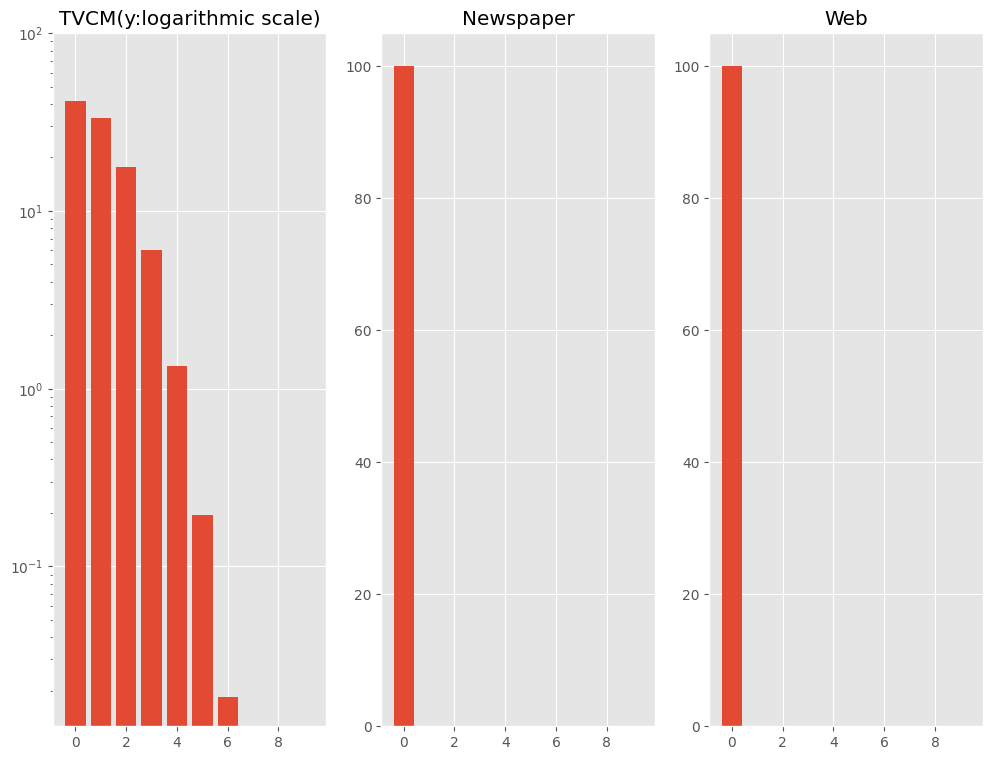

In [20]:
# キャリーオーバー効果モデルの出力例

## サンプルデータ
exp_dat = pd.DataFrame([100,0,0,0,0,0,0,0,0,0])

## ハイパーパラメータ設定

### TVCM
TVCM_carryover_length = optuna_search.best_params_['adstock__TVCM_pipe__carryover__length']
TVCM_carryover_peak = optuna_search.best_params_['adstock__TVCM_pipe__carryover__peak']
TVCM_carryover_rate = optuna_search.best_params_['adstock__TVCM_pipe__carryover__rate']

### Newspaper
Newspaper_carryover_length = optuna_search.best_params_['adstock__Newspaper_pipe__carryover__length']
Newspaper_carryover_peak = optuna_search.best_params_['adstock__Newspaper_pipe__carryover__peak']
Newspaper_carryover_rate = optuna_search.best_params_['adstock__Newspaper_pipe__carryover__rate']

### Web
Web_carryover_length = optuna_search.best_params_['adstock__Web_pipe__carryover__length']
Web_carryover_peak = optuna_search.best_params_['adstock__Web_pipe__carryover__peak']
Web_carryover_rate = optuna_search.best_params_['adstock__Web_pipe__carryover__rate']

## キャリーオーバー効果

### TVCM
exp_co_TVCM= Carryover(
    exp_dat,
    TVCM_carryover_length,
    TVCM_carryover_peak,
    TVCM_carryover_rate,
)

### Newspaper
exp_co_Newspaper = Carryover(
    exp_dat,
    Newspaper_carryover_length,
    Newspaper_carryover_peak,
    Newspaper_carryover_rate,
)

### Web
exp_co_Web = Carryover(
    exp_dat,
    Web_carryover_length,
    Web_carryover_peak,
    Web_carryover_rate,
)

## グラフ
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False)

### TVCM
axes[0].bar(exp_dat.index,
            exp_co_TVCM
           )
axes[0].set_title('TVCM(y:logarithmic scale)')
axes[0].set_yscale('log')
axes[0].set_ylim(0, 100)

### Newspaper
axes[1].bar(exp_dat.index,
            exp_co_Newspaper
           )
axes[1].set_title('Newspaper')

### Web
axes[2].bar(exp_dat.index,
            exp_co_Web
           )
axes[2].set_title('Web')

## 最適なハイパーパラメータでパイプラインを学習
    パイプラインのインスタンスを作ります。

    以下、コードです。

In [21]:
# パイプラインのインスタンス
MMM_pipe_best = MMM_pipe.set_params(**optuna_search.best_params_)

    線形回帰モデルが、どの程度の予測精度を持ったモデルになるのかを確かめるために、時系列のCV（クロスバリデーション）を実施します。今回は、デフォルトの5分割のCVです。

    以下、コードです。

In [22]:
# クロスバリデーションで精度検証（R2）
np.mean(cross_val_score(MMM_pipe_best,
                        X, y,
                        cv=TimeSeriesSplit()
                       )
       )

<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*

0.7643184131146992

    全データでモデルを構築し、予測精度（R**2）を見てみます。

    以下、コードです。

In [23]:
# 全データで精度検証（R2）
MMM_pipe_best.fit(X, y)
MMM_pipe_best.score(X, y)

<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))
<ipython-input-6-ae5b00e1609b>:3: RuntimeWarning: overflow encountered in exp
  return K/(1+b*np.exp(-c*(X-m)))


0.7841623669394289

    前回の線形回帰モデルに比べ、以下のように（R**2）が変化しました。
    ・CVのR **2の平均値：0.70→0.76
    ・全データ利用した場合のR**2：0.74→0.78
    どのような線形回帰モデルなのか（切片と回帰係数）を見てみます。

    以下、コードです。

In [24]:
# 線形回帰モデルの切片と回帰係数
intercept = MMM_pipe_best.named_steps['regression'].intercept_ #切片
coef = MMM_pipe_best.named_steps['regression'].coef_ #回帰係数

# 回帰係数をデータフレーム化
weights = pd.Series(
    coef,
    index=X.columns
)

# 結果出力（切片と係数）
print('Intercept:\n', intercept, sep='')
print()
print('Coefficients:\n',weights, sep='')

Intercept:
1168837.468561505

Coefficients:
TVCM        4.186
Newspaper   1.171
Web         1.972
dtype: float64


## 売上貢献度の算出
    学習し構築したパイプラインの変換器（adstock）を抽出します。

    以下、コードです。

In [25]:
# Piplineの変換器（adstock）を抽出
adstock = MMM_pipe_best.named_steps['adstock']

    説明変数を変換し、学習データのインプットデータを作ります。

    以下、コードです。



In [26]:
# 貢献度（補正前）
unadj_contribution = X_trans.mul(weights) #Xと係数を乗算
unadj_contribution = unadj_contribution.assign(Base=intercept) #切片の追加

unadj_contribution.head() #確認

,TVCM,Newspaper,Web,Base
0,4.186,0.000,0.000,1168837.469
1,4.186,1.171,1.972,1168837.469
2,4.186,1.171,1.972,1168837.469
3,0.000,1.171,0.000,1168837.469
4,0.000,0.000,1.972,1168837.469


    週ごとに各媒体の売上貢献度を合計すると、売上の予測値になります。

    以下、コードです。

In [27]:
# 貢献度の合計（yの予測値）
y_pred = unadj_contribution.sum(axis=1)
y_pred.head() #確認

0   1168841.654
1   1168844.797
2   1168844.797
3   1168838.640
4   1168839.440
dtype: float64

    元の売上の実測値を見てみます。

    以下、コードです。



In [28]:
y.head() #確認

Week
2018-01-07    2132000
2018-01-14    2596100
2018-01-21    2236200
2018-01-28    1680900
2018-02-04    2155400
Name: Sales, dtype: int64

    予測値と実測値が乖離していることが分かります。
    この乖離をなくすために、補正係数（correction factor）を計算し、売上貢献度を補正します。

    補正係数を計算します。

    以下、コードです。

In [29]:
# 補正係数
correction_factor = y.div(y_pred, axis=0)
correction_factor.head() #確認

2018-01-07 00:00:00   NaN
2018-01-14 00:00:00   NaN
2018-01-21 00:00:00   NaN
2018-01-28 00:00:00   NaN
2018-02-04 00:00:00   NaN
dtype: float64

    この補正係数を使い、売上貢献度を補正します。

    以下、コードです。

In [30]:
# 貢献度（補正後）
adj_contribution = (unadj_contribution
                    .mul(correction_factor, axis=0)
                   )

# 順番の変更
adj_contribution = adj_contribution[['Base', 'Web', 'Newspaper', 'TVCM']]

#確認
adj_contribution.head()

<ipython-input-30-3ea8ab471b63>:2: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  adj_contribution = (unadj_contribution


,Base,Web,Newspaper,TVCM
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


    週×媒体別の売上貢献度が求められたので、積み上げグラフを作成し、
    どのような状況になっているのかを確認してみます。

    以下、コードです。

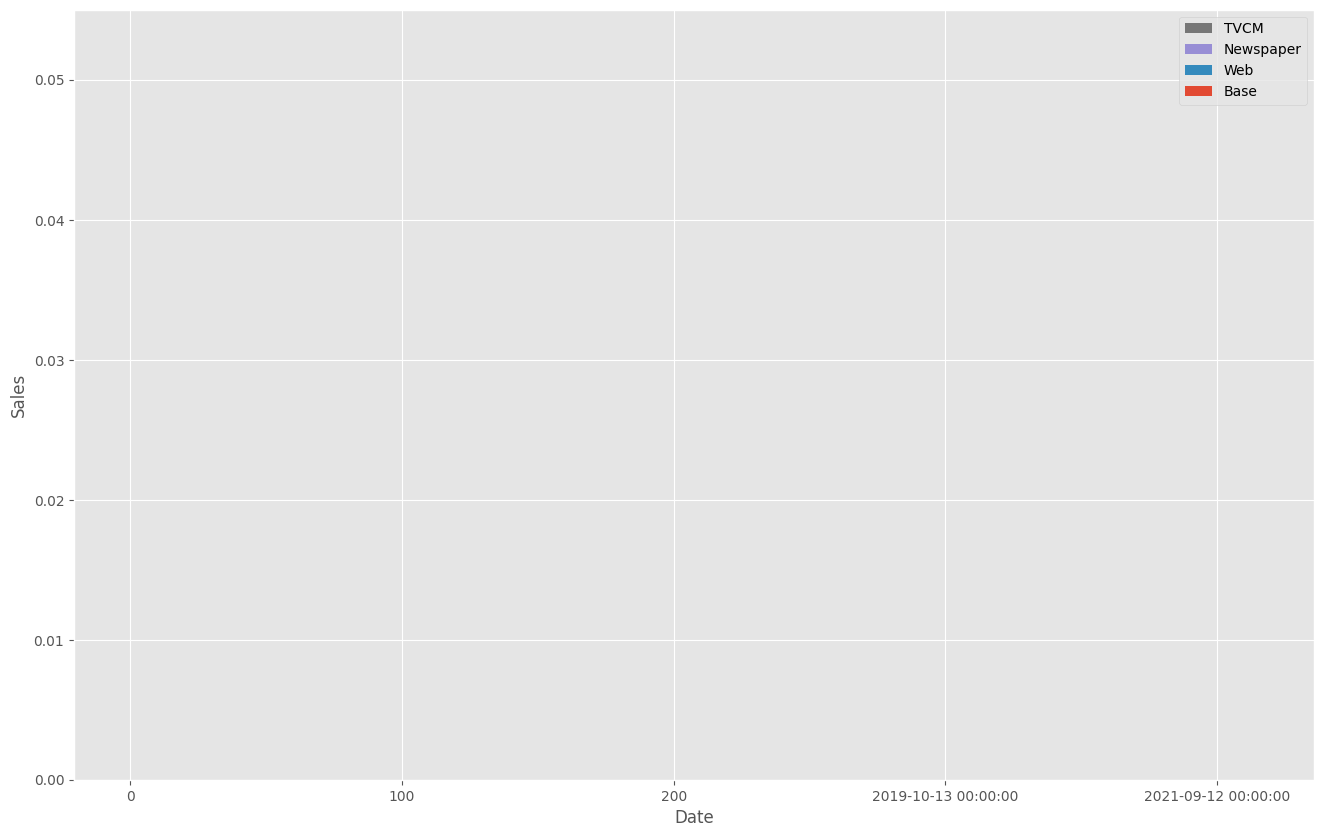

In [31]:
# グラフ化
ax = (adj_contribution
      .plot.area(
          figsize=(16, 10),
          linewidth=0,
          ylabel='Sales',
          xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1])

    媒体別に全ての週の売上貢献度を合計し、媒体別の売上貢献度（円と構成比％）と、
    そのグラフを作り、何がどれほど売上に貢献したのかを見てみます。

    以下、コードです。

In [33]:
# 媒体別の貢献度の合計
contribution_sum = adj_contribution.sum(axis=0)

#集計結果
print('売上貢献度（円）:\n',
      contribution_sum,
      sep=''
     )

print()

print('売上貢献度（構成比）:\n',
      contribution_sum/contribution_sum.sum(),
      sep=''
     )

#グラフ化
contribution_sum.plot.pie(fontsize=24)

売上貢献度（円）:
Base        0.000
Web         0.000
Newspaper   0.000
TVCM        0.000
dtype: float64

売上貢献度（構成比）:
Base        NaN
Web         NaN
Newspaper   NaN
TVCM        NaN
dtype: float64


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:3201: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 1200x900 with 1 Axes>

    費用対効果を見てみます。今回は媒体別にROIを計算します。

    先ず、媒体別のコストを集計します。

    以下、コードです。

In [34]:
# 各媒体のコストの合計
cost_sum = X.sum(axis=0)
cost_sum #確認

TVCM         58147500
Newspaper    45986200
Web          31329300
dtype: int64

    先程求めた売上貢献度を使い、媒体別のROIを計算しグラフ化します。

    以下、コードです。

ROI:
Newspaper   -1.000
TVCM        -1.000
Web         -1.000
dtype: float64


<Axes: >

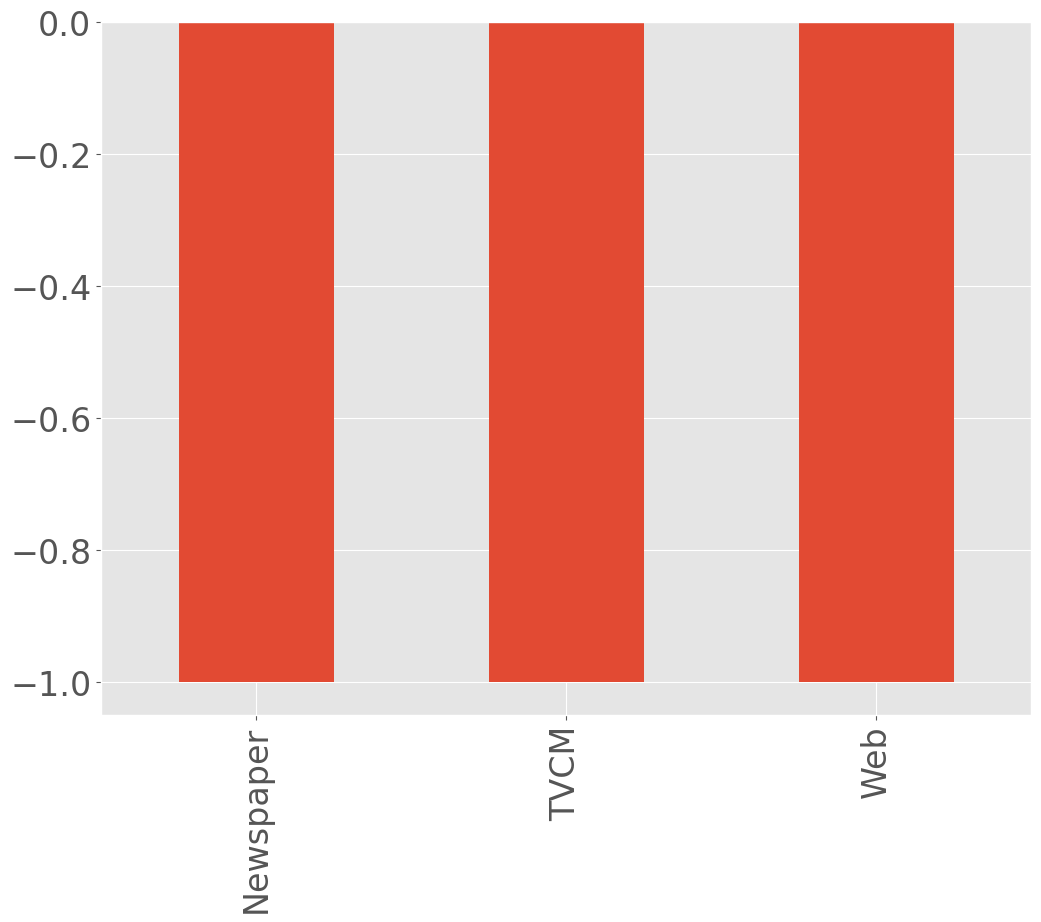

In [35]:
# 各媒体のROIの計算
ROI = (contribution_sum.drop('Base', axis=0) - cost_sum)/cost_sum

#確認
print('ROI:\n', ROI, sep='')

# グラフ化
ROI.plot.bar(fontsize=24)

    ROIは、値が大きいほど良く、最低限プラスの値である必要があります。
    少なくとも0以上である必要があります。

    今までのモデルと比べ、大きな結論は同じです。
    Webが非常にいい、という結論です。

## 次回
    今回は「ちょっと複雑なアドストック（Ad Stock）を考慮した線形回帰モデル」というお話しをしました。

    前回と今回を含め、アドストック（Ad Stock）を表現する幾つかの関数を紹介しました。
    では、アドストック（Ad Stock）を表現する関数の中で、どれがいいのか、という疑問もあるかと思います。

    2つの視点があります。

    ・解釈
    ・精度

    「解釈」とは、アドストック（Ad Stock）を表現する関数が、違和感なく解釈可能なものかかどうか、というものです。

    「精度」とは、目的変数Y（今回の場合：Sales）の予測値と実測値が近い値になっているかどうか、というものです。

    「解釈」は現場感が重要です。
    PCなどで機械的にどうこう検討できるものではありません。

    一方、「精度」は、PCなどで機械的に検討できます。
    最も精度の高いものを探索すればいいからです。

    次回は、「最適なアドストック（Ad Stock）を探索しモデル構築」というお話しをします。